In [69]:
import matplotlib.pyplot as plt
import numpy as np
import seml
import pandas as pd
import json
from collections import defaultdict, Counter
from functools import reduce
import seaborn as sns
from scipy.stats import binned_statistic
from matplotlib.lines import Line2D

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import data.constants as dc

In [4]:
collection_name = 'week18_lipschitz_son'
collection = seml.database.get_collection(collection_name)

In [5]:
by_status = defaultdict(set)
for r in collection.find():
    by_status[r['status']].add(r['config']['data']['dataset'])

In [6]:
by_status

defaultdict(set,
            {'COMPLETED': {'amazon_photo',
              'citeseer',
              'cora_full',
              'ogbn_arxiv'},
             'PENDING': {'amazon_photo', 'citeseer', 'cora_full'}})

In [7]:
collection_name = 'week18_lipschitz_son'
collection = seml.database.get_collection(collection_name)
experiments = [{'config' : r['config'], 'result' : r['result'], 'id' : r['_id']} for r in collection.find() if r['status'] in ('COMPLETED',)]
for ex in experiments:
    # print(ex['result'].keys())
    ex['metrics'] = ex['result']['results']

In [8]:
experiments_killed = [r for r in collection.find() if r['status'] in ('KILLED',)]

In [9]:
set(e['config']['data']['dataset'] for e in experiments_killed)

set()

In [25]:
list(experiments[0]['metrics'].keys())

['accuracy_val_val',
 'accuracy_id_val_val',
 'accuracy_ood_val_val',
 'accuracy_val_no-edges_val',
 'accuracy_id_val_no-edges_val',
 'accuracy_ood_val_no-edges_val',
 'ece_val_val',
 'ece_val_no-edges_val',
 'empirical_lipschitz_val_slope_mean_perturbation_noise_val',
 'empirical_lipschitz_val_slope_median_perturbation_noise_val',
 'empirical_lipschitz_val_slope_max_perturbation_noise_val',
 'empirical_lipschitz_val_slope_min_perturbation_noise_val',
 'empirical_lipschitz_val_slope_mean_perturbation_no-edges_val',
 'empirical_lipschitz_val_slope_median_perturbation_no-edges_val',
 'empirical_lipschitz_val_slope_max_perturbation_no-edges_val',
 'empirical_lipschitz_val_slope_min_perturbation_no-edges_val',
 'accuracy_ood-val_loc-no-edges_val',
 'accuracy_id_ood-val_loc-no-edges_val',
 'accuracy_ood_ood-val_loc-no-edges_val',
 'ood_auroc_total-predictive-entropy_loc-no-edges_val',
 'ood_aucpr_total-predictive-entropy_loc-no-edges_val',
 'misclassification_auroc_total-predictive-entropy_

In [11]:
METRIC = 'Metric'
AUROC = 'AUC-ROC'
AUCPR = 'AUC-PR'

SETTING = 'Setting'
HYBRID = 'Inductive'
TRANSDUCTIVE = 'Transductive'
LOC = 'Leave Out Classes'
NORMAL = 'Normal'
BERNOULLI = 'Bernoulli'
NO_EDGES = 'No Edges'
PROXY = 'Proxy'
EXPERIMENT = 'Experiment'
DATASET = 'Dataset'


RESIDUAL = 'Residual'
SPECTRAL_NORM = 'Spectral Norm'
SPECTRAL_OUTPUT_NORM = 'Spectral Norm on Last Layer'
WEIGHT_SCALE = 'Weight Scale'
LOWER_LIPSCHITZ = 'Empirical Lower Lipschitz Bound'
UPPER_LIPSCHITZ = 'Empirical Upper Lipschitz Bound'



EPISTEMIC = 'Epistemic'
ALEATORIC = 'Aleatoric'

ACCURACY = 'Accuracy'
ECE = 'Expected Calibration Error'

In [12]:
mode = 'val'

In [13]:
ex['config']['model']

{'activation': 'leaky_relu',
 'hidden_sizes': [64],
 'leaky_relu_slope': 0.01,
 'model_type': 'gcn',
 'use_bias': True,
 'use_spectral_norm': True,
 'use_spectral_norm_on_last_layer': True,
 'weight_scale': 5.0,
 'residual': False}

In [51]:
epistemic_proxy = 'ood_gpc-diag-mode:weighted-relative:False:no_fit-95conf'
aleatoric_proxy = 'ood_max-score'
# metric = 'auroc'
# METRIC = 'AUC-ROC'
metric = 'auroc'
METRIC = 'AUROC'

In [70]:
Counter(ex['config']['model']['use_spectral_norm_on_last_layer'] for ex in experiments)

Counter({False: 109, True: 1079})

In [52]:
data_proxy, data_acc_ece = [], []


for ex in experiments:
    cfg = ex['config']
    base = {
        SETTING : {dc.HYBRID : HYBRID, dc.TRANSDUCTIVE : TRANSDUCTIVE}[cfg['data']['setting']],
        RESIDUAL : cfg['model']['residual'],
        SPECTRAL_NORM : cfg['model']['use_spectral_norm'],
        WEIGHT_SCALE : cfg['model']['weight_scale'],
        SPECTRAL_OUTPUT_NORM : cfg['model']['use_spectral_norm_on_last_layer'],
        DATASET :  cfg['data']['dataset'],
        LOWER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_min_perturbation_noise_{mode}'][0]['value'],
        UPPER_LIPSCHITZ : ex['metrics'][f'empirical_lipschitz_{mode}_slope_max_perturbation_noise_{mode}'][0]['value'],
    }
    data_acc_ece.append(base | {
        ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
        ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
    })
    for k, vs in ex['metrics'].items():
        if metric in k and k.endswith('_' + mode):
            k = k.replace(metric + '_', '').replace('_' + mode, '')
            if '-no-edges' in k:
                no_edges = True
                k = k.replace('-no-edges', '')
            else:
                no_edges = False
                
            if '_loc' in k or '-loc' in k:
                exp = LOC
                k = k.replace('_loc', '').replace('-loc', '')
            elif '_ber' in k or '-ber' in k:
                exp = BERNOULLI
                k = k.replace('_ber', '').replace('-ber', '')
            elif '_normal' in k or '-normal' in k:
                exp = NORMAL
                k = k.replace('_normal', '').replace('-normal', '')
            else:
                raise ValueError(k)
            
            metric_cfg = {}
            
            if k == aleatoric_proxy:
                metric_cfg[PROXY] = ALEATORIC
            elif k == epistemic_proxy:
                metric_cfg[PROXY] = EPISTEMIC
            else:
                continue
            
            for v in vs:
                v = v['value']
                data_proxy.append({
                    METRIC : v,
                    NO_EDGES : no_edges,
                    EXPERIMENT : exp,
                } | metric_cfg | base | {
                    ACCURACY : ex['metrics'][f'accuracy_{mode}_{mode}'][0],
                    ECE : ex['metrics'][f'ece_{mode}_{mode}'][0]['value'],
                }
                )
                

In [53]:
df_proxy = pd.DataFrame(data_proxy)
df_acc_ece = pd.DataFrame(data_acc_ece)

In [54]:
df_proxy

,AUROC,No Edges,Experiment,Proxy,Setting,Residual,Spectral Norm,Weight Scale,Spectral Norm on Last Layer,Dataset,Empirical Lower Lipschitz Bound,Empirical Upper Lipschitz Bound,Accuracy,Expected Calibration Error
0,0.911290,True,Leave Out Classes,Aleatoric,Transductive,False,False,1.0,False,cora_full,0.004490,0.787057,0.850000,0.156233
1,0.987657,False,Leave Out Classes,Aleatoric,Transductive,False,False,1.0,False,cora_full,0.004490,0.787057,0.850000,0.156233
2,0.917905,False,Leave Out Classes,Epistemic,Transductive,False,False,1.0,False,cora_full,0.004490,0.787057,0.850000,0.156233
3,0.919814,True,Leave Out Classes,Aleatoric,Transductive,False,False,1.0,False,cora_full,0.005208,0.695869,0.814286,0.156445
4,0.975574,False,Leave Out Classes,Aleatoric,Transductive,False,False,1.0,False,cora_full,0.005208,0.695869,0.814286,0.156445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341,0.593422,False,Bernoulli,Aleatoric,Transductive,False,True,5.0,True,citeseer,0.031448,2.097097,0.666667,0.104126
5342,0.290042,False,Bernoulli,Epistemic,Transductive,False,True,5.0,True,citeseer,0.031448,2.097097,0.666667,0.104126
5343,0.115866,True,Normal,Aleatoric,Transductive,False,True,5.0,True,citeseer,0.031448,2.097097,0.666667,0.104126
5344,0.330200,False,Normal,Aleatoric,Transductive,False,True,5.0,True,citeseer,0.031448,2.097097,0.666667,0.104126


In [60]:
def plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(df, x=None, y=None, row=None, col=None, hue=None, style=None, 
                                      ci=95, 
                                      facet_kws = {'margin_titles' : True, 'height' : 4, }, log_x = True, binned=True):
    
    g = sns.FacetGrid(df, row = row, col = col, hue = hue, **facet_kws)
    
    styles = ['solid', 'dotted', 'dashed']
    markers = ['o', 'x', '+']
    label_to_color = {}
    style_to_linestyle = {}
    style_to_marker = {}
    style_name = style
    
    def plot_lines(x, y, style, sn, color=None, label=None, ci=ci):
        label_to_color[label] = color
        
        for style_idx, st in enumerate(sorted(np.unique(style).tolist())):
            style_to_linestyle[st] = styles[style_idx]
            style_to_marker[st] = markers[style_idx]
            # Bin the ones with spectral norm according to lipschitz constant
            
            x_style, y_style = x[(style == st) & (sn == True)], y[(style == st) & (sn == True)]
            if log_x:
                x_style = np.log(x_style)
            
            if binned:
                if x_style.shape[0] == 0:
                    continue
                else:
                    print(x_style.shape)
                mean, bin_edges, bin_idx = binned_statistic(x_style[np.isfinite(y_style)], y_style[np.isfinite(y_style)], statistic='mean', bins=10)
                std, _, _ = binned_statistic(x_style[np.isfinite(y_style)], y_style[np.isfinite(y_style)], bins=bin_edges, statistic='std')
                bin_centers = (0.5 * (bin_edges[:-1] + bin_edges[1:]))
                if log_x:
                    bin_centers = np.exp(bin_centers)
                
            else:
                bin_centers = np.sort(np.unique(x_style))
                mean = np.array([(y_style[x_style == center]).mean() for center in bin_centers])
                std = np.array([(y_style[x_style == center]).std() for center in bin_centers])
               
            plot_mask = np.isfinite(mean) & np.isfinite(std)

            plt.plot(bin_centers[plot_mask], mean[plot_mask], color=color, label=f'{label}, {st}', linestyle=styles[style_idx])
            plt.fill_between(bin_centers[plot_mask],( mean - std)[plot_mask], (mean + std)[plot_mask], alpha = 0.2, color=color)
             
            # Put the ones without spectral norm into one bin put as a point
            x_style, y_style = x[(style == st) & (sn == False)], y[(style == st) & (sn == False)]
            x_std, y_std = x_style.std(), y_style.std()
            _x, _y = np.array([x_style.mean()]), np.array([y_style.mean()])
            if (np.isfinite(_x) & np.isfinite(_y)).all():
                plt.errorbar(_x, _y, yerr=y_style.std(), xerr = x_style.std(), ecolor='gray', capsize=2, fmt=markers[style_idx], color=color)
        
    g.map(plot_lines, x, y, style, SPECTRAL_NORM, ci=ci)
    
    # Create a legend (extremely hacky)
    
    lines, line_labels = [], []
    for label, color in label_to_color.items():
        lines.append(Line2D([0], [0], color=color))
        line_labels.append(label)
    l1 = plt.legend(lines, line_labels, title=hue, loc='center left', bbox_to_anchor=(1.1, 1.25), frameon=False)
    
    lines, line_labels = [], []
    for style, ls in style_to_linestyle.items():
        lines.append(Line2D([0], [0], color='black', ls=ls))
        line_labels.append(style)
    l2 = plt.legend(lines, line_labels, title=f'{style_name}', loc='center left', bbox_to_anchor=(1.1, 0.99), frameon=False)
    
    
    lines, line_labels = [], []
    for style, marker in style_to_marker.items():
        lines.append(plt.errorbar([], [], xerr=[], yerr=[], color='black', ecolor='gray', capsize=10, fmt=marker))
        line_labels.append(style)
    l3 = plt.legend(lines, line_labels, title=f'{style_name},\nNo Spectral Norm', loc='center left', frameon=False, bbox_to_anchor=(1.1, 0.7))
    
    g.axes.flatten()[-1].add_artist(l1)
    g.axes.flatten()[-1].add_artist(l2)
    
    
    if log_x:
        g.set(xscale='log')
    return g


(90,)
(90,)
(90,)
(90,)
(90,)
(90,)


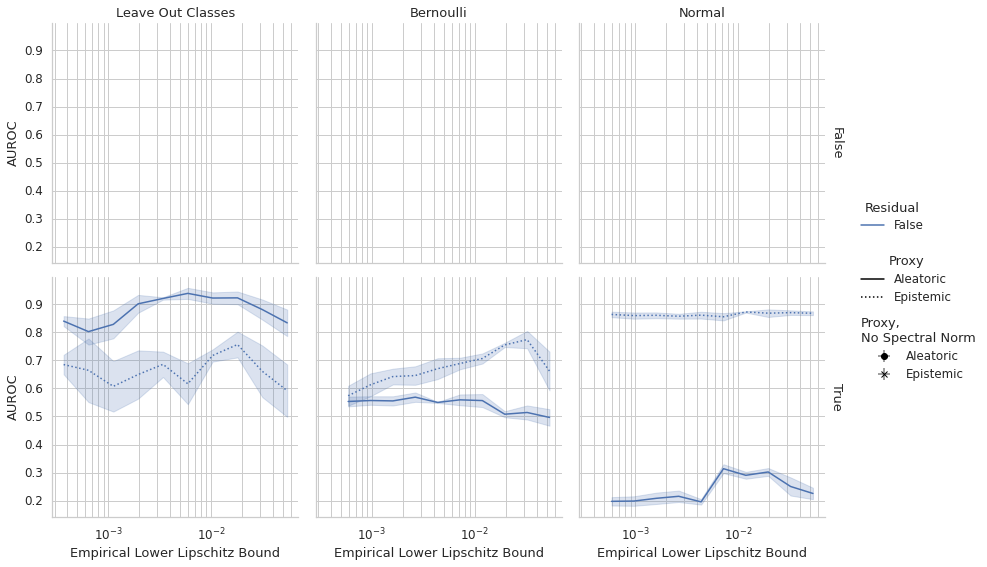

In [61]:

sns.set(context='notebook', font_scale=1.08)
sns.set_style("whitegrid")

g = plot_facet_lines_with_uncertainty_and_no_spectral_norm_as_point(
    df_proxy[
        (df_proxy[NO_EDGES] == False) & 
        (df_proxy[DATASET] == dc.CORA_FULL) &
        (df_proxy[SETTING] == HYBRID)
    ],
    x = LOWER_LIPSCHITZ, y = METRIC, col = EXPERIMENT, row = SPECTRAL_OUTPUT_NORM, hue = RESIDUAL, style = PROXY)
for ax in g.axes.flatten():
    ax.xaxis.grid(True, which='minor')
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')

In [67]:
df_proxy[(df_proxy[SPECTRAL_OUTPUT_NORM]) == False]

,AUROC,No Edges,Experiment,Proxy,Setting,Residual,Spectral Norm,Weight Scale,Spectral Norm on Last Layer,Dataset,Empirical Lower Lipschitz Bound,Empirical Upper Lipschitz Bound,Accuracy,Expected Calibration Error
0,0.911290,True,Leave Out Classes,Aleatoric,Transductive,False,False,1.0,False,cora_full,0.004490,0.787057,0.850000,0.156233
1,0.987657,False,Leave Out Classes,Aleatoric,Transductive,False,False,1.0,False,cora_full,0.004490,0.787057,0.850000,0.156233
2,0.917905,False,Leave Out Classes,Epistemic,Transductive,False,False,1.0,False,cora_full,0.004490,0.787057,0.850000,0.156233
3,0.919814,True,Leave Out Classes,Aleatoric,Transductive,False,False,1.0,False,cora_full,0.005208,0.695869,0.814286,0.156445
4,0.975574,False,Leave Out Classes,Aleatoric,Transductive,False,False,1.0,False,cora_full,0.005208,0.695869,0.814286,0.156445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4693,0.450011,False,Bernoulli,Aleatoric,Inductive,False,False,1.0,False,citeseer,0.012398,0.819009,0.658333,0.092112
4694,0.439218,False,Bernoulli,Epistemic,Inductive,False,False,1.0,False,citeseer,0.012398,0.819009,0.658333,0.092112
4695,0.179626,True,Normal,Aleatoric,Inductive,False,False,1.0,False,citeseer,0.012398,0.819009,0.658333,0.092112
4696,0.380092,False,Normal,Aleatoric,Inductive,False,False,1.0,False,citeseer,0.012398,0.819009,0.658333,0.092112


In [68]:
np.unique(df_proxy[SPECTRAL_OUTPUT_NORM], return_counts=True)

(array([False,  True]), array([ 489, 4857]))